In this notebook we will test the accuracy  

In [1]:
# IMPORTs
from utils.task import Task
import json
import os
from src.pipeline.schema_selection_fusion import schema_selection_fusion
from utils.database_utils.db_info import get_db_schema
from tqdm import tqdm
from dotenv import load_dotenv
from utils.sql_query_parsers import get_sql_columns_dict
import matplotlib.pyplot as plt
import numpy as np

load_dotenv()

True

In [2]:
# Function to load JSON data
def load_json_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data


# Function to create task object
def create_task(example):
    return Task(example)

In [3]:
# load the task data
filepath = "C:/Users\yousf\Bureau\ConvergenceAI\CHESS_Impl\data/test/subsampled_test.json"
data = load_json_data(filepath)
# load the retrieved entities
filepath_entities = "C:/Users\yousf\Bureau\ConvergenceAI\CHESS_Impl\data/test/retrieved_entities.json"
retrieved_entities = load_json_data(filepath_entities)
# load the retrieved context
filepath_context = "C:/Users\yousf\Bureau\ConvergenceAI\CHESS_Impl\data/test/retrieved_context.json"
retrieved_context = load_json_data(filepath_context)

In [4]:
# test column selection module with a random sample
index = 1
example = data[index]
task = create_task(example)

#get the database schema
dp_path = os.getenv("DB_ROOT_PATH") + f"/{task.db_id}/{task.db_id}.sqlite"
schema = get_db_schema(dp_path)
model = "llama-3"
ans = schema_selection_fusion(task=task, retrieved_entities=retrieved_entities[index],
                              retrieved_context=retrieved_context[index], tentative_schema=schema, model=model,
                              num_samples=1)
ans

{'selected_schema': {'frpm': ['CDSCode',
   'Low Grade',
   'High Grade',
   'NSLP Provision Status'],
  'schools': ['CDSCode', 'County', 'City', 'EILCode']},
 'chain_of_thought_reasoning': "The question asks for the city location of a high school level school with Lunch Provision 2, lowest grade 9, and highest grade 12 in the county of Merced. The hint suggests that EILCode = 'HS' represents high school. We need to find the school with this characteristic and then retrieve its city location. The tables frpm and schools contain relevant information. The column County in the schools table helps filter schools by county, and the column City in the same table provides the city location. The column EILCode in the schools table matches the hint, and the columns Low Grade and High Grade in the frpm table match the grade requirements. The column NSLP Provision Status in the frpm table matches the Lunch Provision 2 requirement."}

In [4]:
#test context retrieval module with the subsampled test and with the base schema of database
model = "gpt-4"
num_samples = 1
res = []
for index, sample in tqdm(enumerate(data)):
    task = create_task(sample)
    dp_path = os.getenv("DB_ROOT_PATH") + f"/{task.db_id}/{task.db_id}.sqlite"
    schema = get_db_schema(dp_path)

    ans = schema_selection_fusion(task=task, retrieved_entities=retrieved_entities[index],
                                  retrieved_context=retrieved_context[index], tentative_schema=schema, model=model,
                                  num_samples=num_samples)
    res.append(ans)
    print(str(index) + " : ", ans)

0it [00:06, ?it/s]

KeyboardInterrupt



# Metrics

In [5]:
def calculate_precision_recall_f1(tp, fp, fn):
    """
    Calculate precision, recall, and F1 score.
    
    Args:
        tp (int): Number of true positives.
        fp (int): Number of false positives.
        fn (int): Number of false negatives.
    
    Returns:
        Tuple[float, float, float]: Precision, recall, and F1 score.
    """
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1


def evaluate_schema(ground_truth, predicted):
    """
    Evaluate the schema prediction against the ground truth.
    
    Args:
        ground_truth (Dict[str, List[str]]): Ground truth schema with tables and their columns.
        predicted (Dict[str, List[str]]): Predicted schema with tables and their columns.
    
    Returns:
        Dict[str, Dict[str, float]]: Evaluation results for tables and columns.
    """

    # Transform all table and column names to lowercase
    ground_truth = {table.lower(): [col.lower() for col in columns] for table, columns in ground_truth.items()}
    predicted = {table.lower(): [col.lower() for col in columns] for table, columns in predicted.items()}

    # Evaluate tables
    gt_tables = set(ground_truth.keys())
    pred_tables = set(predicted.keys())

    tp_tables = len(gt_tables.intersection(pred_tables))
    fp_tables = len(pred_tables.difference(gt_tables))
    fn_tables = len(gt_tables.difference(pred_tables))

    table_precision, table_recall, table_f1 = calculate_precision_recall_f1(tp_tables, fp_tables, fn_tables)

    # Evaluate columns
    tp_columns = 0
    fp_columns = 0
    fn_columns = 0

    for table in gt_tables:
        gt_columns = set(ground_truth[table])
        pred_columns = set(predicted.get(table, []))

        tp_columns += len(gt_columns.intersection(pred_columns))
        fp_columns += len(pred_columns.difference(gt_columns))
        fn_columns += len(gt_columns.difference(pred_columns))

    column_precision, column_recall, column_f1 = calculate_precision_recall_f1(tp_columns, fp_columns, fn_columns)

    return {
        "table_metrics": {
            "precision": table_precision,
            "recall": table_recall,
            "f1": table_f1
        },
        "column_metrics": {
            "precision": column_precision,
            "recall": column_recall,
            "f1": column_f1
        }
    }


def aggregate_metrics(evals):
    """
    Aggregate precision, recall, and F1 scores from multiple evaluations.
    
    Args:
        evals (List[Dict[str, Dict[str, float]]]): List of evaluation results.
    
    Returns:
        Dict[str, float]: Aggregated precision, recall, and F1 score.
    """
    table_precision = np.mean([evaluation['table_metrics']['precision'] for evaluation in evals])
    table_recall = np.mean([evaluation['table_metrics']['recall'] for evaluation in evals])
    table_f1 = np.mean([evaluation['table_metrics']['f1'] for evaluation in evals])

    column_precision = np.mean([evaluation['column_metrics']['precision'] for evaluation in evals])
    column_recall = np.mean([evaluation['column_metrics']['recall'] for evaluation in evals])
    column_f1 = np.mean([evaluation['column_metrics']['f1'] for evaluation in evals])

    return {
        "table_metrics": {
            "precision": table_precision,
            "recall": table_recall,
            "f1": table_f1
        },
        "column_metrics": {
            "precision": column_precision,
            "recall": column_recall,
            "f1": column_f1
        }
    }


def plot_metrics(metrics):
    """
    Plot precision, recall, and F1 score.
    
    Args:
        metrics (Dict[str, Dict[str, float]]): Aggregated metrics.
    """
    categories = ['Tables', 'Columns']

    precision_values = [
        metrics['table_metrics']['precision'],
        metrics['column_metrics']['precision']
    ]

    recall_values = [
        metrics['table_metrics']['recall'],
        metrics['column_metrics']['recall']
    ]

    f1_values = [
        metrics['table_metrics']['f1'],
        metrics['column_metrics']['f1']
    ]

    x = np.arange(len(categories))
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width, precision_values, width, label='Precision')
    rects2 = ax.bar(x, recall_values, width, label='Recall')
    rects3 = ax.bar(x + width, f1_values, width, label='F1 Score')

    ax.set_ylabel('Scores')
    ax.set_title('Average Precision, Recall, and F1 Score for Tables and Columns')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.ylim(0, 1)  # Set y-axis range from 0 to 1
    plt.show()


def make_test(data, model, num_samples):
    res = []
    for index, sample in tqdm(enumerate(data)):
        task = create_task(sample)
        dp_path = os.getenv("DB_ROOT_PATH") + f"/{task.db_id}/{task.db_id}.sqlite"
        schema = get_db_schema(dp_path)

        ans = schema_selection_fusion(task=task, retrieved_entities=retrieved_entities[index],
                                      retrieved_context=retrieved_context[index], tentative_schema=schema, model=model,
                                      num_samples=num_samples)
        res.append(ans)

    evals = []
    for i, schema in enumerate(res):
        pred = schema["selected_schema"]
        task = create_task(data[i])
        db_path = os.getenv("DB_ROOT_PATH") + f"/{task.db_id}/{task.db_id}.sqlite"
        gt = get_sql_columns_dict(db_path, task.SQL)
        evaluation = evaluate_schema(gt, pred)
        evals.append(evaluation)

    aggregated_metrics = aggregate_metrics(evals)
    print("Aggregated Metrics:", aggregated_metrics)

    plot_metrics(aggregated_metrics)


15it [02:04,  8.32s/it]


Aggregated Metrics: {'table_metrics': {'precision': 0.9444444444444444, 'recall': 0.9666666666666667, 'f1': 0.9422222222222222}, 'column_metrics': {'precision': 0.9266666666666666, 'recall': 0.8796825396825396, 'f1': 0.8977777777777778}}


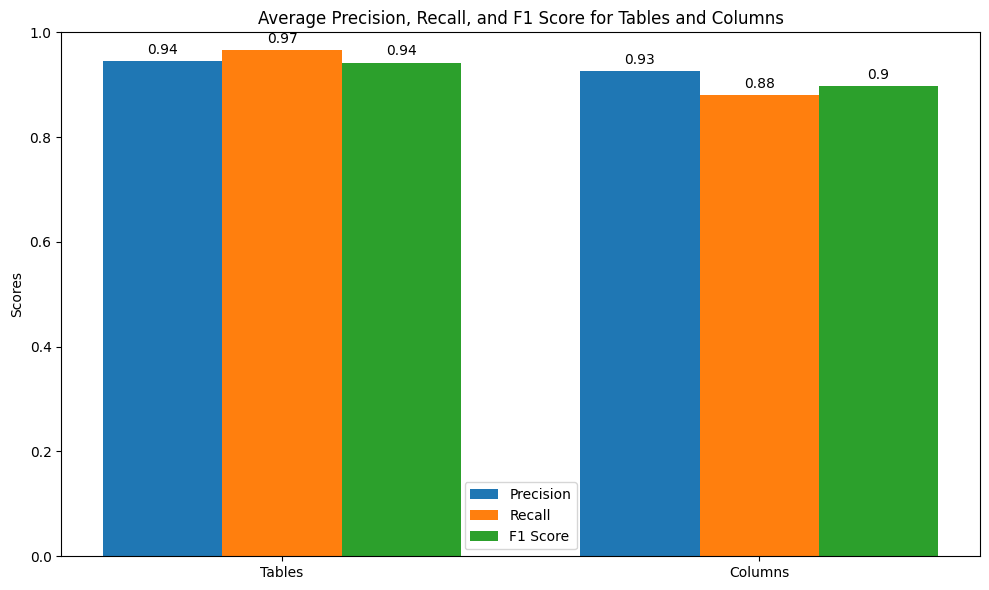

In [6]:
model = "gpt-4"
num_samples = 1
make_test(data, model, num_samples)

15it [06:04, 24.33s/it]


Aggregated Metrics: {'table_metrics': {'precision': 0.9444444444444444, 'recall': 0.9666666666666667, 'f1': 0.9422222222222222}, 'column_metrics': {'precision': 0.9018181818181819, 'recall': 0.913015873015873, 'f1': 0.8986267533635955}}


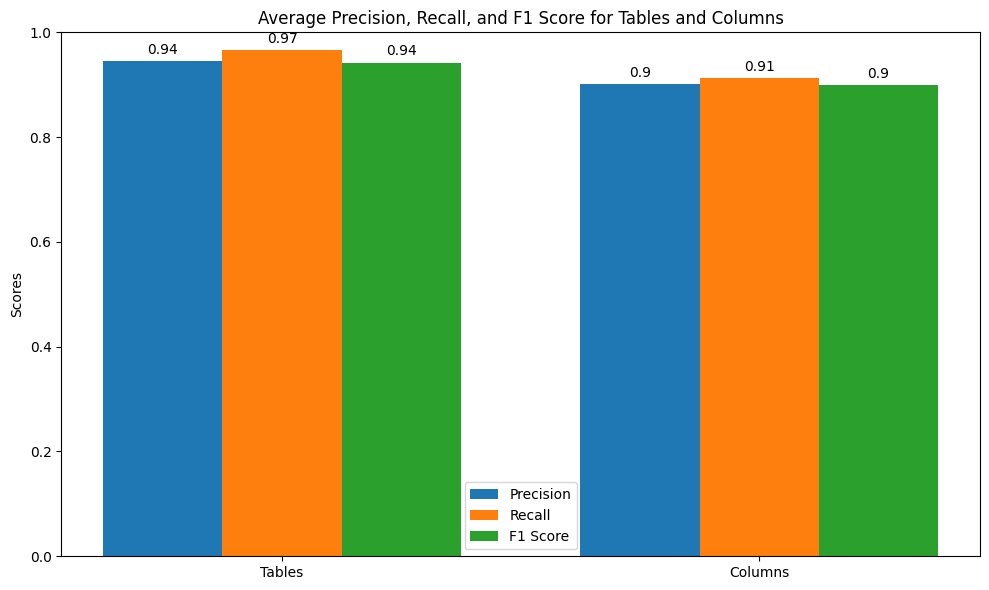

In [7]:
model = "gpt-4"
num_samples = 3
make_test(data, model, num_samples)